### COMP 542 - Machine Learning Cryptocurrency Analysis: Multiple Case Studies

#### By: Isaac Garcia & Brent Gibson (Group 8)


##### Case Study 1: Discovering new cryptocurrencies with potential through means of clustering.

Objective: take a list of 8218 from CryptoCompare API cryptocurrencies and their information, cleanse it, and create clusters. Ideally, investors would want to invest in the safest cryptocurrencies in the same cluster as Bitcoin, Ethereum, Litecoin, as these are more promising.

In [11]:
import urllib.request, json 
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler


with urllib.request.urlopen("https://min-api.cryptocompare.com/data/all/coinlist") as url:
    data = json.loads(url.read().decode())
    
data=data['Data']


df = pd.DataFrame.from_dict(data)
df2 = df.transpose()
df2 = df2.filter(['CoinName', 'Algorithm', 'IsTrading', 'ProofType', 'TotalCoinsMined', 'CirculatingSupply'],axis=1)
df2.tail()

,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,CirculatingSupply
UNDEAD,Undead Blocks,N/A,True,N/A,500000000,0
SLEEPEE,SleepFuture,N/A,True,N/A,1431241.007423,0
PETO,Petoverse,N/A,False,N/A,1030423.75343,0
FLD,FLUID,N/A,False,N/A,NaN,NaN
GARTS,Glink Arts Share,N/A,True,N/A,0,0


In [12]:
df2.shape


(8226, 6)

We're only interested in the cryptos that are active and are being mined, so that this gets rid of the NaN entries which would mess up the training.

In [45]:
# data cleaning
df2 = df2[df2.IsTrading != 0]
df2 = df2.drop(columns="IsTrading")
df2 = df2[~(df2.TotalCoinsMined <= 0)]
#df2 = df2[~(df2.CirculatingSupply <= 0)]
df2 = df2.dropna()
df2.shape

AttributeError: 'DataFrame' object has no attribute 'IsTrading'

From the original 8218 currencies, there are only 2850 now after filtering that we need to cluster

In [47]:
# coin name column provides no value but will be needed later
names = pd.DataFrame(df2.CoinName)
df2 = df2.drop(columns="CoinName")
df2.head()

AttributeError: 'DataFrame' object has no attribute 'CoinName'

Removing extra redundancies from the data

In [15]:
X = pd.get_dummies(df2, columns=["Algorithm", "ProofType"])
print(X.shape)
X.head()

(2857, 116)


,TotalCoinsMined,CirculatingSupply,Algorithm_Autolykos,Algorithm_BEP-2,Algorithm_BEP-2 Token,Algorithm_BEP-20 Token,Algorithm_BLAKE256,Algorithm_BMW512 / Echo512,Algorithm_Blake2B + SHA3,Algorithm_Blake2b,...,ProofType_TPoS,ProofType_XRP LCP,ProofType_Zero-Knowledge Proof,ProofType_dPoS,ProofType_dPoS/BFT,ProofType_dPoW,ProofType_dPoW/PoW,ProofType_ePoW,ProofType_fPoW + PBFT,ProofType_nPoS/PoC
42,41.999952,41.999952,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
300,300,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NSR,6177452125.8373,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TRI,191623.903871,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CMTC,872830,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [69]:
scaler = StandardScaler()
data2 = scaler.fit_transform(X)
data2[0:5]

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
data_pca = pca.fit_transform(data2)
data_pca

array([[ 7.43616145, -0.27177657],
       [-0.59951698,  0.01726469],
       [ 5.51049117, -0.54630274],
       ...,
       [ 2.26477628, -0.03390518],
       [-0.59951698,  0.01726469],
       [-0.59951698,  0.01726469]])

In [70]:
pc = pd.DataFrame(data_pca, columns=["PC 1", "PC 2"], index=names.index)
pc.head()

,PC 1,PC 2
42,7.436161,-0.271777
300,-0.599517,0.017265
NSR,5.510491,-0.546303
TRI,7.131251,-0.883997
CMTC,7.163832,0.017692


[14270.547663774809, 7253.601785068411, 2475.58109357161, 1092.4870337676182, 280.58132646280694, 183.555359766978, 126.64959278395537, 91.36481251570967, 73.53769482152964, 58.63130283353209]


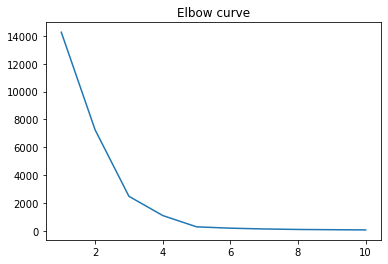

In [71]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
# surely there will need to be less than 11 clusters
k = list(range(1,11))
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(pc)
    inertia.append(km.inertia_)
    
print(inertia)
plt.plot(k, inertia)
plt.title('Elbow curve')

plt.show()

From the elbow curve, tt appears that 3 clusters is optimal.

In [72]:
km_model = KMeans(n_clusters=3, random_state=0)
km_model.fit(pcs_df)
predictions = km_model.predict(pcs_df)
predictions
clustered_df = pd.concat([df2, pcs_df], axis=1, join='inner')
clustered_df["CoinName"] = names.CoinName
clustered_df["Class"] = km_model.labels_
print(clustered_df.shape)
clustered_df.head(10)


(2857, 8)


,Algorithm,ProofType,TotalCoinsMined,CirculatingSupply,PC 1,PC 2,CoinName,Class
42,Scrypt,PoW/PoS,41.999952,41.999952,7.418203,-1.093562,42 Coin,1
300,N/A,N/A,300,0,-0.600254,0.015486,300 token,0
NSR,PoS,PoS,6177452125.8373,0,5.644069,-1.700278,NuShares,1
TRI,X13,PoW/PoS,191623.903871,0,7.114520,-1.262271,Triangles Coin,1
CMTC,Scrypt,PoW,872830,0,7.150711,-0.640195,CometCoin,1
BITCNY,N/A,N/A,20723205,0,-0.600254,0.015486,bitCNY,0
NXC,N/A,N/A,66509518.5,0,-0.600254,0.015486,Nexium,0
CHAT,Scrypt,PoW/PoS,1000000000,0,7.418203,-1.093562,OpenChat,1
WGR,N/A,PoS,246000837.106829,0,2.311522,-0.602503,Wagerr,0
LA,N/A,N/A,400000000,0,-0.600254,0.015486,LATOKEN,0


In [73]:
filtered_c0 = clustered_df[clustered_df['Class'] == 0] 
filtered_c1 = clustered_df[clustered_df['Class'] == 1] 
filtered_c2 = clustered_df[clustered_df['Class'] == 2] 

print("Amount of currencies in class 0 (best): " + str(len(filtered_c0)))
print("Amount of currencies in class 1 (average): " + str(len(filtered_c1)))
print("Amount of currencies in class 2 (worst): "+ str(len(filtered_c2)))

Amount of currencies in class 0 (best): 2695
Amount of currencies in class 1 (average): 160
Amount of currencies in class 2 (worst): 2


## Currencies in class 0

In [21]:
class0 = filtered_c0.index.tolist()
print(class0)

['300', 'BITCNY', 'NXC', 'WGR', 'LA', 'CVCOIN', 'MOBI', 'ARNX', 'SOMA', 'CLD', 'MGO', 'MDCL', 'PROPS', 'PAN', '0XBTC', 'VITE', 'GTK', 'WPP', 'ENQ', 'EURS', 'NHCT', 'CSP', 'USDC', 'VEX', 'MYO', 'WOM', 'SILKT', 'ZUC', 'HRD', 'LEVL', 'EVED', '2KEY', 'KICKS', 'IOWN', 'BRYLL', 'NNB', 'GMAT', 'FOIN', 'LXT', 'BHP', 'XCHF', 'PNK', 'THEX', 'UAT', 'VINCI', 'XSR', 'NYE', 'EMRX', 'PLAC', 'LTBTC', 'UNICORN', 'SUTER', 'DAD', 'SNL', 'XFC', 'BRZ', 'ECP', 'CNTM', 'QTCON', 'BOA', 'NVL', 'XTP', 'BNP', 'APM', 'ALY', 'JOB', 'GIX', 'BEP', 'AIDUS', 'NWC', 'EOSBULL', 'XRPBEAR', 'BNBBULL', 'TRXBULL', 'TRXBEAR', 'LTCBULL', 'LTCBEAR', 'HBD', 'ELAMA', 'ANCT', 'USDJ', 'UPEUR', 'LCX', 'COSP', 'HUNT', 'ALTBEAR', 'DEP', 'HMR', 'LMCH', 'BSVBULL', 'BSVBEAR', 'BCHBULL', 'BCHBEAR', 'STAKE', 'IBVOL', 'XTZBULL', 'XTZBEAR', 'LOON', 'FORESTPLUS', 'XPR', 'UTI', 'ASM', 'KDAG', 'RAD.CUR', 'ADABEAR', 'ADABULL', 'ATOMBULL', 'ATOMBEAR', 'ALGOBULL', 'ALGOBEAR', 'TOMOBULL', 'MIDBEAR', 'BTMXBULL', 'PMGT', 'PAZZI', 'ISP', 'WEST', 'OKS

## Currencies in class 1:

In [22]:
class1 = filtered_c1.index.tolist()
print(class1)

['42', 'NSR', 'TRI', 'CMTC', 'CHAT', 'PURA', 'ADK', 'DAPS', 'VEIL', 'MWC', 'RVC', 'TTT', 'XDNA', 'WBBC', 'TPAY', 'ETZ', 'SIN', 'QRK', 'UEC', 'MTRG', 'AR', 'BTH', 'BCMC1', 'RBTC', 'UBTC', 'VID', 'VRC', 'EMC', 'PIN', 'COVAL', 'ERG', 'GENIX', 'BEAM', 'RTM', 'USDP', 'STRAX', 'AEON', 'TENT', 'ARRR', 'INT', 'SFP', 'CKB', 'HNS', 'AURORAC', 'VAL', 'ENS', 'NIM', 'AMB', 'BTCZ', 'XEC', 'SATS', 'ANC', 'EXP', 'BDX', 'SIGNA', 'MAPS', 'CDN', 'BTCP', 'BLOCKN', 'EMC2', 'USX', 'QRL', 'RDD', 'SYS', 'AION', 'MEC', 'APTCOIN', 'TAU', 'TORCOIN', 'CZZ', 'TECRA', 'FOREXCOIN', 'UBQ', 'SUPERC', 'STEEM', 'XSN', 'SHIFT', 'BLOCM', 'RISEVISION', 'QTUM', 'XDN', 'DOGE', 'ONT', 'FLO', 'GRIN', 'NLG', 'IOC', 'MONA', 'XWC', 'BTC', 'BCD', 'BSV', 'VET', 'FIRO', 'BTS', 'BTT', 'BLK', 'SIB', 'SC', 'SERO', 'SLS', 'RCN', 'DASH', 'DERO', 'GRS', 'HLC', 'ZEN', 'ETN', 'NMC', 'NANO', 'PIVX', 'ZEL', 'ZEC', 'ACT', 'AE', 'ARK', 'WAVES', 'FTC', 'GAMECRED', 'VIA', 'VTC', 'XVG', 'VRA', 'VSYS', 'GO', 'GLC', 'BNB', 'BCH', 'BTG', 'XHV', 'SOLV

## Currencies in class 2:

In [23]:
class2 = filtered_c2.index.tolist()
print(class2)

['NXS', 'AAC']


##### Case Study 2: Sampling the top class 0 currencies on CoinMarketCap.com and finding out their correlation to bitcoin price fluctuations. Predicting future prices is also discussed.

This is helpful because if you are thinking of buying a certain cryptocurrency, you would not want to buy it when Bitcoin is down if it has a high correlation to the crypto you're interested in.

In [74]:
import numpy as np
import pandas as pd
import datetime as dt

Importing Litecoin data for the past year

In [75]:
ltc_data = pd.read_csv('LTC-USD.csv', index_col='Date')
ltc_data['symbol']='LTC'
ltc_data.head()

,Open,High,Low,Close,Adj Close,Volume,symbol
Date,,,,,,,
2021-05-09,347.090027,388.232788,335.173462,386.450775,386.450775,9835832552,LTC
2021-05-10,387.869171,412.960144,339.138947,359.329315,359.329315,13240769672,LTC
2021-05-11,359.258087,378.859131,345.298828,377.388794,377.388794,8798204078,LTC
2021-05-12,377.670532,393.132477,303.084869,303.084869,303.084869,8782996412,LTC
2021-05-13,310.102386,332.028473,292.280670,316.909332,316.909332,9777636796,LTC


Importing Ethereum data for the past year

In [76]:
eth_data = pd.read_csv('ETH-USD.csv', index_col='Date')
eth_data['symbol']='ETH'
eth_data.head()

,Open,High,Low,Close,Adj Close,Volume,symbol
Date,,,,,,,
2021-05-09,3911.463135,3981.259033,3743.989014,3928.844727,3928.844727,50568290278,ETH
2021-05-10,3924.413330,4197.473145,3684.451660,3952.293945,3952.293945,62691789007,ETH
2021-05-11,3948.271973,4178.208984,3783.889404,4168.701172,4168.701172,52679737865,ETH
2021-05-12,4174.635742,4362.350586,3785.848633,3785.848633,3785.848633,69023382175,ETH
2021-05-13,3828.918457,4032.563477,3549.407227,3715.148438,3715.148438,78398214539,ETH


Importing Binance Coin data for the past year

In [77]:
bnb_data = pd.read_csv('BNB-USD.csv', index_col='Date')
bnb_data['symbol']='BNB'
bnb_data.head()

,Open,High,Low,Close,Adj Close,Volume,symbol
Date,,,,,,,
2021-05-09,646.312134,678.228394,631.465271,662.228577,662.228577,4321052943,BNB
2021-05-10,661.450012,690.931946,596.165894,631.351990,631.351990,5157435389,BNB
2021-05-11,631.240601,672.459412,623.249817,672.333923,672.333923,4865455319,BNB
2021-05-12,671.778870,684.137695,588.185181,588.185181,588.185181,4311561442,BNB
2021-05-13,592.954590,632.970703,530.238220,571.434509,571.434509,7417114170,BNB


Importing Dogecoin data for the past year

In [78]:
doge_data = pd.read_csv('DOGE-USD.csv', index_col='Date')
doge_data['symbol']='DOGE'
doge_data.head()

,Open,High,Low,Close,Adj Close,Volume,symbol
Date,,,,,,,
2021-05-09,0.635820,0.697625,0.425706,0.570070,0.570070,46138063928,DOGE
2021-05-10,0.569687,0.569687,0.421291,0.449964,0.449964,16514521828,DOGE
2021-05-11,0.450488,0.546651,0.445034,0.495231,0.495231,14566975476,DOGE
2021-05-12,0.493742,0.519975,0.385376,0.385376,0.385376,8621337859,DOGE
2021-05-13,0.392176,0.519461,0.357175,0.490374,0.490374,18663174069,DOGE


Importing Cardano data for the past year

In [79]:
ada_data = pd.read_csv('ADA-USD.csv', index_col='Date')
ada_data['symbol']='ADA'
ada_data.head()

,Open,High,Low,Close,Adj Close,Volume,symbol
Date,,,,,,,
2021-05-09,1.620347,1.829795,1.575998,1.770562,1.770562,8065503276,ADA
2021-05-10,1.766068,1.822609,1.529308,1.644696,1.644696,6463330466,ADA
2021-05-11,1.641717,1.778112,1.596676,1.764077,1.764077,5428571805,ADA
2021-05-12,1.763505,1.818942,1.552775,1.552775,1.552775,5338469591,ADA
2021-05-13,1.568450,1.969934,1.505321,1.933668,1.933668,14513419581,ADA


In [80]:
cs2_data = pd.concat([eth_data, ltc_data, doge_data, ada_data, bnb_data])
cs2_data.shape

(1830, 7)

In [81]:
cs2_data.head()

,Open,High,Low,Close,Adj Close,Volume,symbol
Date,,,,,,,
2021-05-09,3911.463135,3981.259033,3743.989014,3928.844727,3928.844727,50568290278,ETH
2021-05-10,3924.413330,4197.473145,3684.451660,3952.293945,3952.293945,62691789007,ETH
2021-05-11,3948.271973,4178.208984,3783.889404,4168.701172,4168.701172,52679737865,ETH
2021-05-12,4174.635742,4362.350586,3785.848633,3785.848633,3785.848633,69023382175,ETH
2021-05-13,3828.918457,4032.563477,3549.407227,3715.148438,3715.148438,78398214539,ETH


Import bitcoin data to create a matrix of strictly close values that will be used for the heatmap.

In [82]:
btc_data = pd.read_csv('BTC-USD.csv', index_col='Date')
btc_data['symbol']='BTC'
btc_data.head()

,Open,High,Low,Close,Adj Close,Volume,symbol
Date,,,,,,,
2021-05-09,58877.390625,59210.882813,56482.003906,58232.316406,58232.316406,65906690347,BTC
2021-05-10,58250.871094,59519.355469,54071.457031,55859.796875,55859.796875,71776546298,BTC
2021-05-11,55847.242188,56872.542969,54608.652344,56704.574219,56704.574219,61308396325,BTC
2021-05-12,56714.531250,57939.363281,49150.535156,49150.535156,49150.535156,75215403907,BTC
2021-05-13,49735.433594,51330.843750,46980.019531,49716.191406,49716.191406,96721152926,BTC


In [83]:
btc_close = btc_data[['Close']]
btc_close.columns = ['BTC']

ltc_close = ltc_data[['Close']]
ltc_close.columns = ['LTC']

ada_close = ada_data[['Close']]
ada_close.columns = ['ADA']

doge_close = doge_data[['Close']]
doge_close.columns = ['DOGE']

eth_close = eth_data[['Close']]
eth_close.columns = ['ETH']

bnb_close = bnb_data[['Close']]
bnb_close.columns = ['BNB']


matrix = pd.concat([btc_close,ltc_close,ada_close,doge_close,eth_close,bnb_close], axis=1)
matrix.head()


,BTC,LTC,ADA,DOGE,ETH,BNB
Date,,,,,,
2021-05-09,58232.316406,386.450775,1.770562,0.570070,3928.844727,662.228577
2021-05-10,55859.796875,359.329315,1.644696,0.449964,3952.293945,631.351990
2021-05-11,56704.574219,377.388794,1.764077,0.495231,4168.701172,672.333923
2021-05-12,49150.535156,303.084869,1.552775,0.385376,3785.848633,588.185181
2021-05-13,49716.191406,316.909332,1.933668,0.490374,3715.148438,571.434509


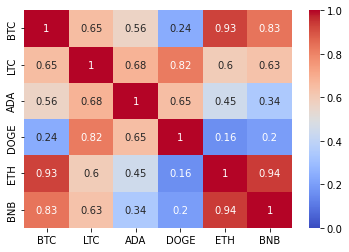

In [84]:
import seaborn as sb

sb.heatmap(matrix.corr(),vmin=0, vmax=1, cmap='coolwarm', annot=True)
plt.show()

Surprisingly, some of the class 0 cryptocurrencies analyzed show weak correlation with bitcoin's price in the past year. Only ethereum and binance coin appear to strongly fluctuate with bitcoin due to its very high correlation coefficient (0.93, 0.83). This means that there are other factors to consider if investing in others like LTC, ADA, and especially DOGE with the lowest coefficient.

Text(0.5, 1.0, 'Litecoin closing price in the past year')

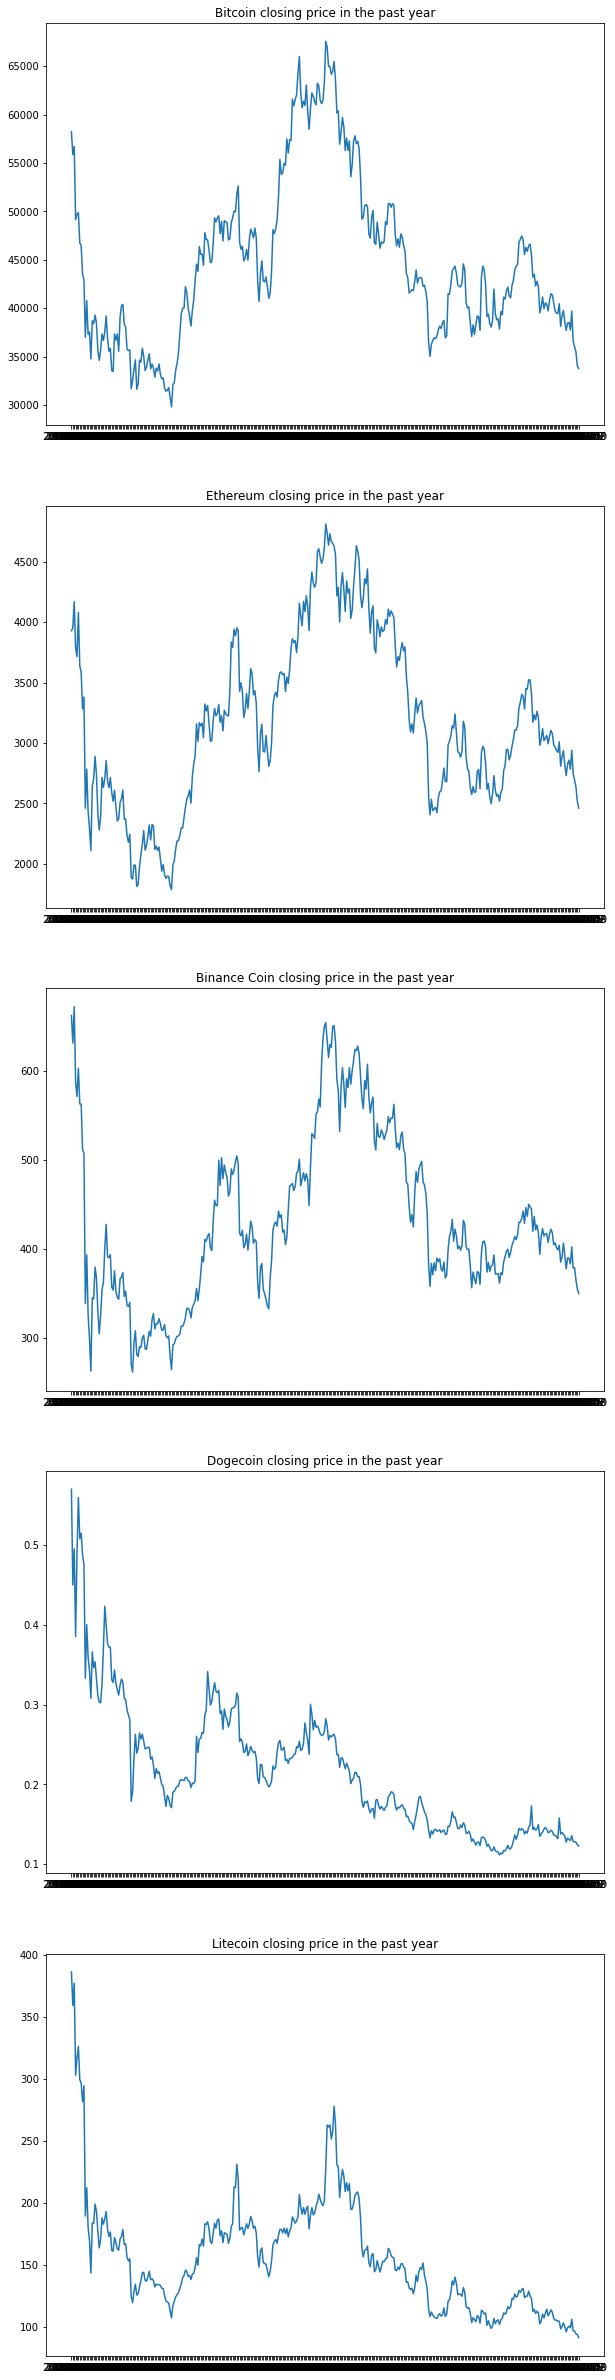

In [85]:
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(10, 30))
plt.subplots_adjust(left=None, bottom=-0.2, right=None, top=None, wspace=.2, hspace=.2)

ax[0].plot(btc_data[['Close']])
ax[0].set_title("Bitcoin closing price in the past year")

ax[1].plot(eth_data[['Close']])
ax[1].set_title("Ethereum closing price in the past year")

ax[2].plot(bnb_data[['Close']])
ax[2].set_title("Binance Coin closing price in the past year")

ax[3].plot(doge_data[['Close']])
ax[3].set_title("Dogecoin closing price in the past year")

ax[4].plot(ltc_data[['Close']])
ax[4].set_title("Litecoin closing price in the past year")

The Ethereum and Binance Coin closing charts mimic Bitcoin's graph very heavily. This information is useful for developing trading strategies.

## Continuation


Next, we will try implementing an LSTM model to attempt to predict the price for the next day of these same currencies (ADA, BTC, ETH, DOGE, BNB).

In [86]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding


scaler = MinMaxScaler(feature_range = (0, 1))
scaled_data = scaler.fit_transform(btc_data['Close'].values.reshape(-1,1))

# use only the past 30 days for predicting
prediction_days = 30

x_train, y_train = [], []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x - prediction_days: x, 0])
    y_train.append(scaled_data[x, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
model = Sequential()

model.add(LSTM(units = 32, return_sequences = True, input_shape = (x_train.shape[1], 1)))

model.add(Dense(units = 1))

# adam optimizer is the best applying gradient descent learning with 
# an eta (learning rate) of 0.01

model.compile(optimizer = 'adam', loss = 'mean_squared_error')
lstm = model.fit(x_train, y_train, epochs = 50, batch_size = 128, validation_split = 0.3)

Epoch 1/50
2/2 [==============================] - 2s 526ms/step - loss: 0.4196 - val_loss: 0.1369
Epoch 2/50
2/2 [==============================] - 0s 54ms/step - loss: 0.3656 - val_loss: 0.1133
Epoch 3/50
2/2 [==============================] - 0s 56ms/step - loss: 0.3181 - val_loss: 0.0930
Epoch 4/50
2/2 [==============================] - 0s 111ms/step - loss: 0.2770 - val_loss: 0.0755
Epoch 5/50
2/2 [==============================] - 0s 67ms/step - loss: 0.2419 - val_loss: 0.0604
Epoch 6/50
2/2 [==============================] - 0s 147ms/step - loss: 0.2111 - val_loss: 0.0476
Epoch 7/50
2/2 [==============================] - 0s 55ms/step - loss: 0.1837 - val_loss: 0.0368
Epoch 8/50
2/2 [==============================] - 0s 62ms/step - loss: 0.1596 - val_loss: 0.0280
Epoch 9/50
2/2 [==============================] - 0s 51ms/step - loss: 0.1397 - val_loss: 0.0213
Epoch 10/50
2/2 [==============================] - 0s 59ms/step - loss: 0.1232 - val_loss: 0.0169
Epoch 11/50
2/2 [=========

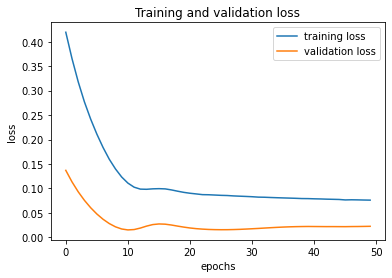

In [87]:
plt.plot(lstm.history['loss'])
plt.plot(lstm.history['val_loss'])
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['training loss', 'validation loss'])
plt.show()

Not sure if this model is overfitting or underfitting because the losses are not converging and the validation loss starts to increase. We can try to add another LSTM layer to the model including Dropout, which helps with regularization and prediction accuracy.

In [88]:
model = Sequential()

model.add(LSTM(units = 32, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2)) 

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')
lstm = model.fit(x_train, y_train, epochs = 50, batch_size = 128, validation_split = 0.3)

Epoch 1/50
2/2 [==============================] - 2s 361ms/step - loss: 0.2264 - val_loss: 0.0623
Epoch 2/50
2/2 [==============================] - 0s 75ms/step - loss: 0.1990 - val_loss: 0.0498
Epoch 3/50
2/2 [==============================] - 0s 52ms/step - loss: 0.1757 - val_loss: 0.0392
Epoch 4/50
2/2 [==============================] - 0s 56ms/step - loss: 0.1563 - val_loss: 0.0303
Epoch 5/50
2/2 [==============================] - 0s 61ms/step - loss: 0.1389 - val_loss: 0.0231
Epoch 6/50
2/2 [==============================] - 0s 59ms/step - loss: 0.1248 - val_loss: 0.0176
Epoch 7/50
2/2 [==============================] - 0s 60ms/step - loss: 0.1137 - val_loss: 0.0140
Epoch 8/50
2/2 [==============================] - 0s 64ms/step - loss: 0.1059 - val_loss: 0.0127
Epoch 9/50
2/2 [==============================] - 0s 56ms/step - loss: 0.1020 - val_loss: 0.0135
Epoch 10/50
2/2 [==============================] - 0s 69ms/step - loss: 0.1012 - val_loss: 0.0154
Epoch 11/50
2/2 [===========

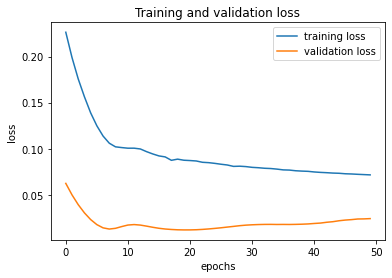

In [89]:
plt.plot(lstm.history['loss'])
plt.plot(lstm.history['val_loss'])
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['training loss', 'validation loss'])
plt.show()

A little better. I think the model is still underfit so we can add another LSTM layer to see how it affects the model. Add another LSTM layer with the same parameters.

In [90]:
model = Sequential()

model.add(LSTM(units = 32, return_sequences = True))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')
lstm = model.fit(x_train, y_train, epochs = 50, batch_size = 128, validation_split = 0.3)

Epoch 1/50
2/2 [==============================] - 2s 470ms/step - loss: 0.2036 - val_loss: 0.0511
Epoch 2/50
2/2 [==============================] - 0s 73ms/step - loss: 0.1746 - val_loss: 0.0381
Epoch 3/50
2/2 [==============================] - 0s 65ms/step - loss: 0.1501 - val_loss: 0.0274
Epoch 4/50
2/2 [==============================] - 0s 71ms/step - loss: 0.1321 - val_loss: 0.0195
Epoch 5/50
2/2 [==============================] - 0s 70ms/step - loss: 0.1186 - val_loss: 0.0146
Epoch 6/50
2/2 [==============================] - 0s 62ms/step - loss: 0.1105 - val_loss: 0.0128
Epoch 7/50
2/2 [==============================] - 0s 59ms/step - loss: 0.1076 - val_loss: 0.0134
Epoch 8/50
2/2 [==============================] - 0s 55ms/step - loss: 0.1091 - val_loss: 0.0148
Epoch 9/50
2/2 [==============================] - 0s 59ms/step - loss: 0.1086 - val_loss: 0.0155
Epoch 10/50
2/2 [==============================] - 0s 66ms/step - loss: 0.1068 - val_loss: 0.0153
Epoch 11/50
2/2 [===========

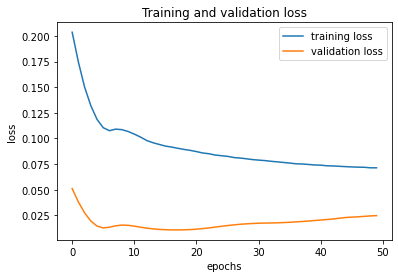

In [92]:
plt.plot(lstm.history['loss'])
plt.plot(lstm.history['val_loss'])
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['training loss', 'validation loss'])
plt.show()

The third LSTM layer does not seem to help. There is probably not enough data to properly train the model. Since yahoo finance limits us to only 365 data points for each currency, we need more data to optimize this model. In comparison with the thousands of data points from the IMDB data used in the lecture to train an LSTM model. We will use the 2nd model with 2 LSTM layers to continue with the predictive model.

## Model testing

In [129]:
btc_model_data = btc_data['Close']
btc_model_data = btc_model_data.to_frame()

btc_model_data = btc_model_data.reshape(-1, 1)# 219

btc_model_data = scaler.fit_transform(btc_model_data)
#btc_model_data = btc_data[len(btc_data) - prediction_days - 255 :].values
#btc_model_data = btc_model_data.reshape(-1, 1)# 219
#btc_model_data = scaler.fit_transform(btc_model_data)

AttributeError: 'DataFrame' object has no attribute 'reshape'